In [1]:
import torch
import numpy as np
import cv2
import os
import random as rand
import torchvision
import pandas as pd
from tqdm import tqdm
from torch import nn, Tensor
import matplotlib.pyplot as plt
from typing import Optional
from torch.nn import functional as F
from torchvision.transforms import v2 as T
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from math import ceil

In [2]:
class CIFAR(Dataset):
    def __init__(self, path="/scratch/s25090/archive/cifar-10/train", dataset:Optional[list]=None):
        super().__init__()
        self.path = path
        self.files = os.listdir(self.path) if dataset is None else dataset
        self.T = T.Compose([
           T.ToImage(), 
           T.ToDtype(torch.float32, scale=True),
           T.Resize((32, 32)),
           T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self,):
        return len(self.files)
    
    def __getitem__(self, idx):
        file = self.files[idx]
        img_path = os.path.join(self.path, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.T(img)
        return img

class MNISTCSV(Dataset):
    def __init__(self, csv_file):
        # 1. Read the CSV
        data = pd.read_csv(csv_file)
        
        # 2. Extract Labels
        self.labels = torch.tensor(data.iloc[:, 0].values, dtype=torch.long)
        
        # 3. Extract Images
        # We keep them as uint8 (0-255) to save memory and let transforms handle scaling later
        images = data.iloc[:, 1:].values.reshape(-1, 28, 28).astype('uint8')
        self.images = torch.from_numpy(images) # Shape: (N, 28, 28)

        # 4. Define Transforms (v2)
        self.transforms = T.Compose([
           T.ToImage(),                           # Converts to Tensor (C, H, W)
           T.Grayscale(num_output_channels=3),    # <--- FORCES 3 CHANNELS (RGB)
           T.Resize((32, 32)),                    # Resize to 32x32
           T.ToDtype(torch.float32, scale=True),  # Converts 0-255 int to 0.0-1.0 float
           T.Normalize(mean=[0.5, 0.5, 0.5],      # Normalize for 3 channels
                       std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        
        # Apply the transformation pipeline
        if self.transforms:
            img = self.transforms(img)
            
        return img, label

In [3]:
class GenBlock(nn.Module):
    def __init__(self, in_channel, out_channel, is_final):
        super().__init__()
        layers = [
            nn.Conv2d(in_channel, (out_channel+in_channel)//2, 3, 1, 1),
            nn.BatchNorm2d((out_channel+in_channel)//2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d((in_channel+out_channel)//2, out_channel, 3, 1, 1)
        ]
        
        if not is_final:
            layers.append(nn.BatchNorm2d(out_channel))
            layers.append(nn.LeakyReLU(0.2, inplace=True))

        layers.append(nn.UpsamplingNearest2d(scale_factor=2))
        self.layer = nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)

class DisBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channel, (out_channel+in_channel)//2, 3, 1, 1),
            nn.BatchNorm2d((out_channel+in_channel)//2),
            nn.LeakyReLU(0.2),
            nn.Conv2d((out_channel+in_channel)//2, out_channel, 3, 1, 1),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2)
        )
    
    def forward(self, x):
        return self.layer(x)

class ResGenBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        )
        
        self.shortcut = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)
        )

    def forward(self, x):
        return self.conv_block(x) + self.shortcut(x)

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.initial_linear = nn.Linear(z_dim, 1024 * 4 * 4)
        
        self.net = nn.Sequential(
            GenBlock(1024, 512, is_final=False), 
            GenBlock(512, 256, is_final=False),  
            GenBlock(256, 128,  is_final=False), 
            GenBlock(128,  64,  is_final=False),
            GenBlock(64,  64,  is_final=True),
        )
        
        self.final_layer = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        if len(z.shape) > 2:
            z = z.view(z.size(0), -1)
            
        x = self.initial_linear(z)
        x = x.view(-1, 1024, 4, 4)
        x = self.net(x)
        return self.final_layer(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            DisBlock(3, 32),   
            DisBlock(32, 64),
            DisBlock(64, 128),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 1) 
        )

    def forward(self, x):
        x = self.net(x)
        return self.classifier(x)

class ResNetGenerator(nn.Module):
    def __init__(self, z_dim=100, base_channels=256):
        super().__init__()
        self.linear = nn.Linear(z_dim, 4 * 4 * base_channels)
        self.base_channels = base_channels

        self.blocks = nn.Sequential(
            ResGenBlock(base_channels, base_channels),    
            ResGenBlock(base_channels, base_channels // 2), 
            ResGenBlock(base_channels // 2, base_channels // 4),
        )
        
        self.final_layer = nn.Sequential(
            nn.BatchNorm2d(base_channels // 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels // 4, 3, 3, 1, 1), 
            nn.Tanh() 
        )

    def forward(self, z):
        if z.ndim > 2: z = z.view(z.size(0), -1)
            
        x = self.linear(z)
        x = x.view(-1, self.base_channels, 4, 4)
        x = self.blocks(x)
        return self.final_layer(x)

class GANModel(nn.Module):
    def __init__(self, z_dim=100, is_res=True):
        super().__init__()
        self.generator = Generator(z_dim) if not is_res else ResNetGenerator()
        self.discriminator = Discriminator()
        self.z_dim = z_dim
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, z):
        return self.generator(z)

    def compute_discriminator_loss(self, real_imgs, z):
        batch_size = real_imgs.size(0)
        device = real_imgs.device
        
        with torch.no_grad():
            fake_imgs = self.generator(z).detach()

        real_logits = self.discriminator(real_imgs)
        fake_logits = self.discriminator(fake_imgs)

        real_labels = torch.full_like(real_logits, 0.9, device=device) 
        real_loss = self.criterion(real_logits, real_labels)
        fake_labels = torch.zeros_like(fake_logits, device=device)
        fake_loss = self.criterion(fake_logits, fake_labels)

        d_loss = (real_loss + fake_loss) / 2
        return d_loss

    def compute_generator_loss(self, z):
        fake_imgs = self.generator(z)
        fake_logits = self.discriminator(fake_imgs)
        target_labels = torch.ones_like(fake_logits).to(fake_logits.device)
        g_loss = self.criterion(fake_logits, target_labels)
        return g_loss, fake_imgs

Epoch-201/1000: 100%|██████████| 469/469 [03:42<00:00,  2.11it/s, GenLoss=5.63, DisLoss=0.217, DisSteps=1]


Generator Loss: 4.156082279392397
Discriminator Loss: 0.2154138905407269


Epoch-202/1000: 100%|██████████| 469/469 [04:00<00:00,  1.95it/s, GenLoss=3.89, DisLoss=0.179, DisSteps=1]


Generator Loss: 4.330924699047227
Discriminator Loss: 0.2048683685343911


Epoch-203/1000: 100%|██████████| 469/469 [03:29<00:00,  2.24it/s, GenLoss=4.1, DisLoss=0.19, DisSteps=1]  


Generator Loss: 4.532590859988605
Discriminator Loss: 0.2013380570706528


Epoch-204/1000: 100%|██████████| 469/469 [03:16<00:00,  2.38it/s, GenLoss=4.82, DisLoss=0.186, DisSteps=1]


Generator Loss: 4.44543356224418
Discriminator Loss: 0.19689818857702365


Epoch-205/1000: 100%|██████████| 469/469 [03:31<00:00,  2.22it/s, GenLoss=6.03, DisLoss=0.18, DisSteps=1] 


Generator Loss: 4.331187961960652
Discriminator Loss: 0.20986388197966985


Epoch-206/1000: 100%|██████████| 469/469 [03:43<00:00,  2.10it/s, GenLoss=4.79, DisLoss=0.192, DisSteps=1]


Generator Loss: 4.317564147621838
Discriminator Loss: 0.20377636276709754


Epoch-207/1000: 100%|██████████| 469/469 [03:50<00:00,  2.04it/s, GenLoss=4.74, DisLoss=0.173, DisSteps=1]


Generator Loss: 4.564303574531571
Discriminator Loss: 0.19493745181606267


Epoch-208/1000: 100%|██████████| 469/469 [04:19<00:00,  1.81it/s, GenLoss=2.87, DisLoss=0.212, DisSteps=1]


Generator Loss: 4.048966691692247
Discriminator Loss: 0.21677016236507562


Epoch-209/1000: 100%|██████████| 469/469 [04:49<00:00,  1.62it/s, GenLoss=3.68, DisLoss=0.237, DisSteps=1]


Generator Loss: 4.32010746561388
Discriminator Loss: 0.21272176844097657


Epoch-210/1000: 100%|██████████| 469/469 [03:52<00:00,  2.02it/s, GenLoss=4.98, DisLoss=0.19, DisSteps=1] 


Generator Loss: 4.469111809090002
Discriminator Loss: 0.208043325334978


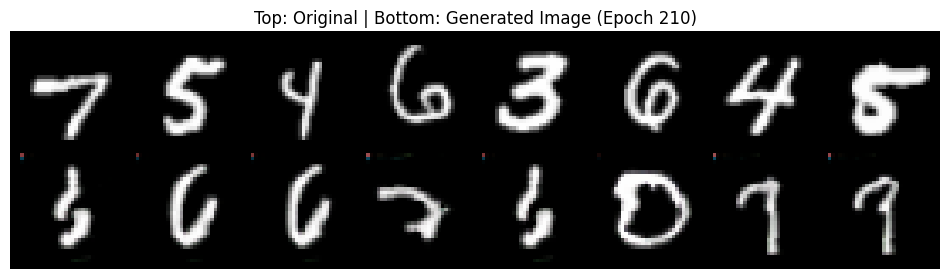

Epoch-211/1000: 100%|██████████| 469/469 [04:12<00:00,  1.86it/s, GenLoss=5.08, DisLoss=0.192, DisSteps=1]


Generator Loss: 4.689227020816762
Discriminator Loss: 0.19139180133846015


Epoch-212/1000: 100%|██████████| 469/469 [04:02<00:00,  1.94it/s, GenLoss=4.14, DisLoss=0.197, DisSteps=1]


Generator Loss: 4.391952620386315
Discriminator Loss: 0.1990775491700752


Epoch-213/1000: 100%|██████████| 469/469 [03:22<00:00,  2.32it/s, GenLoss=4.73, DisLoss=0.18, DisSteps=1] 


Generator Loss: 4.3296404784676366
Discriminator Loss: 0.20700849262254833


Epoch-214/1000: 100%|██████████| 469/469 [03:37<00:00,  2.15it/s, GenLoss=4.37, DisLoss=0.203, DisSteps=1]


Generator Loss: 4.276285774926387
Discriminator Loss: 0.19959287135712883


Epoch-215/1000: 100%|██████████| 469/469 [04:24<00:00,  1.77it/s, GenLoss=3.61, DisLoss=0.192, DisSteps=1]


Generator Loss: 4.53667936497914
Discriminator Loss: 0.20278185526572312


Epoch-216/1000: 100%|██████████| 469/469 [04:17<00:00,  1.82it/s, GenLoss=3.58, DisLoss=0.218, DisSteps=1]


Generator Loss: 4.372467318577553
Discriminator Loss: 0.20423814072919044


Epoch-217/1000: 100%|██████████| 469/469 [04:13<00:00,  1.85it/s, GenLoss=5.42, DisLoss=0.199, DisSteps=1]


Generator Loss: 4.419099473749905
Discriminator Loss: 0.20070728580199326


Epoch-218/1000: 100%|██████████| 469/469 [04:15<00:00,  1.84it/s, GenLoss=3.79, DisLoss=0.228, DisSteps=1]


Generator Loss: 4.0736312073176855
Discriminator Loss: 0.21423312195582683


Epoch-219/1000: 100%|██████████| 469/469 [05:07<00:00,  1.53it/s, GenLoss=3.07, DisLoss=0.229, DisSteps=1]


Generator Loss: 4.310674811222914
Discriminator Loss: 0.20970119443783627


Epoch-220/1000: 100%|██████████| 469/469 [03:57<00:00,  1.98it/s, GenLoss=4.75, DisLoss=0.201, DisSteps=1]


Generator Loss: 4.290363417505455
Discriminator Loss: 0.21127246682450715


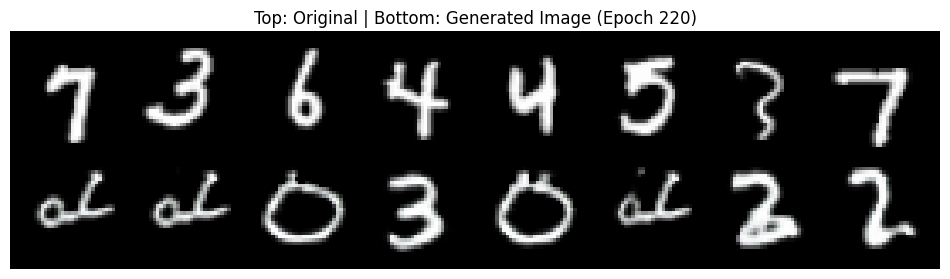

Epoch-221/1000: 100%|██████████| 469/469 [01:47<00:00,  4.38it/s, GenLoss=4.5, DisLoss=0.181, DisSteps=1] 


Generator Loss: 4.241148833526985
Discriminator Loss: 0.2026976680259969


Epoch-222/1000: 100%|██████████| 469/469 [01:46<00:00,  4.40it/s, GenLoss=4.22, DisLoss=0.208, DisSteps=1]


Generator Loss: 4.649379104439384
Discriminator Loss: 0.19081087975995117


Epoch-223/1000:  16%|█▌        | 73/469 [00:16<03:14,  2.04it/s, GenLoss=4.93, DisLoss=0.177, DisSteps=1]

In [ ]:
epochs=1000
warmup_epochs = 10
dis_schedule = np.linspace(5, 1, num=warmup_epochs)
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'
gan_model = GANModel()
gan_model = gan_model.to(DEVICE)
opt_gen = torch.optim.Adam(gan_model.generator.parameters(), lr=1e-4)
opt_dis = torch.optim.Adam(gan_model.discriminator.parameters(), lr=1e-4)
train_dataset = MNISTCSV("/scratch/s25090/archive/mnist/mnist_train.csv")
test_dataset = MNISTCSV("/scratch/s25090/archive/mnist/mnist_test.csv")
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# l1_loss = nn.L1Loss()

# gen_loss_list = []
# dis_loss_list = []

for epoch in range(epochs):
    tot_gen_loss = 0
    tot_dis_loss = 0
    gan_model.train()
    tqdm_data = tqdm(train_loader, desc=f"Epoch-{epoch+1}/{epochs}")
    dis_steps = ceil(dis_schedule[epoch]) if epoch+1 < warmup_epochs else 1
    i=0
    for real_img, _ in tqdm_data:
        i+=1
        real_img = real_img.to(DEVICE)
        bs = real_img.size(0)
        if i%dis_steps==0:
            z_dis = torch.randn(bs, 100).to(DEVICE)
            opt_dis.zero_grad()
            dis_loss = gan_model.compute_discriminator_loss(real_img, z_dis)
            dis_loss.backward()
            opt_dis.step()
        else:
            dis_loss = torch.tensor(0.0).to(DEVICE)

        for param in gan_model.discriminator.parameters():
            param.requires_grad = False

        z = torch.randn(bs, 100).to(DEVICE)
        opt_gen.zero_grad()
        gen_loss, fake_img = gan_model.compute_generator_loss(z)
        gen_loss.backward()
        opt_gen.step()

        tot_gen_loss+=gen_loss.detach().cpu().item()
        tot_dis_loss+=dis_loss.detach().cpu().item()
        tqdm_data.set_postfix({
            "GenLoss":gen_loss.detach().cpu().item(),
            "DisLoss":dis_loss.detach().cpu().item(),
            "DisSteps":dis_steps
        })

        for param in gan_model.discriminator.parameters():
            param.requires_grad = True

    
    gen_loss_list.append(tot_gen_loss/len(train_loader))
    dis_loss_list.append(tot_dis_loss*dis_steps/len(train_loader))

    print(f"Generator Loss: {gen_loss_list[-1]}\nDiscriminator Loss: {dis_loss_list[-1]}")

    if (epoch + 1) % 10 == 0:
        torch.save(gan_model.state_dict(), f'/scratch/s25090/gan_outputs/weights/Experiment_mnist/gan_epoch_{epoch+1}.pth')
        gan_model.eval()
        with torch.no_grad():
            gan_image = gan_model(z)
            comparison = torch.cat([real_img[:8], gan_image[:8]], dim=0)
            grid = make_grid(comparison.cpu(), nrow=8, padding=2, normalize=True)
            plt.figure(figsize=(12, 4))
            plt.imshow(grid.permute(1, 2, 0))
            plt.axis('off')
            plt.title(f'Top: Original | Bottom: Generated Image (Epoch {epoch+1})')
            plt.savefig(f"/scratch/s25090/gan_outputs/plots/Experiment_mnist/Epoch-{epoch+1}.png")
            plt.show()
            plt.close()

plt.figure(figsize=(10, 5))
plt.title("Generator vs Discriminator Loss")
plt.plot(gen_loss_list, label="Generator")
plt.plot(dis_loss_list, label="Discriminator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig(f"/scratch/s25090/gan_outputs/plots/Experiment_mnist.png")
plt.legend()
plt.show()